# AI Accelerated – Episode 1
## Why CUDA Matters for AI

In this episode, we introduce the **fundamental reasons** why CUDA is central to AI acceleration. We compare CPUs vs GPUs, explore SIMD vs SIMT, and demonstrate vector addition on CPU vs GPU.

### 🎯 Learning Goals
- Understand the difference between **CPU SIMD (AVX)** and **GPU SIMT (CUDA)**
- Learn how **memory hierarchy** differs (CPU cache vs GPU VRAM)
- Run a **CPU vector add** program vs a **GPU CUDA kernel**
- Connect this to **AI workloads** (why GPUs dominate training)


### 🖥️ CPU vs GPU Architecture
- **CPU**: few powerful cores, optimized for latency
- **GPU**: thousands of lightweight cores, optimized for throughput

Analogy: CPU = few fast lanes, GPU = thousands of scooters moving together 🚦

### 💻 CPU Vector Addition Example

In [19]:
%%writefile cpu_vector_add.c

#include <stdio.h>
#include <stdlib.h>
#include <time.h>

double elapsed(struct timespec start, struct timespec end) {
    return (end.tv_sec - start.tv_sec) + (end.tv_nsec - start.tv_nsec) / 1e9;
}

int main() {
    const int N = 1 << 24; // ~16 million
    float *a = malloc(N*sizeof(float));
    float *b = malloc(N*sizeof(float));
    float *c = malloc(N*sizeof(float));

    for (int i = 0; i < N; i++) { a[i] = 1.0f; b[i] = 2.0f; }

    struct timespec start, end;
    clock_gettime(CLOCK_MONOTONIC, &start);

    for (int i = 0; i < N; i++) {
        c[i] = a[i] + b[i];
    }

    clock_gettime(CLOCK_MONOTONIC, &end);
    printf("c[0]=%f c[%d]=%f\n", c[0], N-1, c[N-1]);
    printf("Elapsed time: %.6f ms\n", elapsed(start, end) * 1000);

    free(a); free(b); free(c);
}


Overwriting cpu_vector_add.c


In [20]:
!gcc cpu_vector_add.c -o cpu_vector_add && ./cpu_vector_add

c[0]=3.000000 c[16777215]=3.000000
Elapsed time: 57.367574 ms


### 💻 SIMD Vector Addition Example (AVX2/AVX256)

In [16]:
%%writefile avx256_vector_add.c
#include <immintrin.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

double elapsed(struct timespec start, struct timespec end) {
    return (end.tv_sec - start.tv_sec) + (end.tv_nsec - start.tv_nsec) / 1e9;
}

int main() {
    const int N = 1 << 24; // ~16 million
    float *a = aligned_alloc(32, N*sizeof(float));
    float *b = aligned_alloc(32, N*sizeof(float));
    float *c = aligned_alloc(32, N*sizeof(float));

    for (int i = 0; i < N; i++) { a[i] = 1.0f; b[i] = 2.0f; }

    struct timespec start, end;
    clock_gettime(CLOCK_MONOTONIC, &start);

    for (int i = 0; i < N; i += 8) {
        __m256 va = _mm256_load_ps(&a[i]);
        __m256 vb = _mm256_load_ps(&b[i]);
        __m256 vc = _mm256_add_ps(va, vb);
        _mm256_store_ps(&c[i], vc);
    }

    clock_gettime(CLOCK_MONOTONIC, &end);
    printf("c[0]=%f c[%d]=%f\n", c[0], N-1, c[N-1]);
    printf("Elapsed time: %.6f ms\n", elapsed(start, end) * 1000);

    free(a); free(b); free(c);
}

Overwriting avx256_vector_add.c


In [17]:
!gcc -O2 -mavx2 avx256_vector_add.c -o avx_vector_add
# gcc -O2 -mavx512f avx_vector_add.c -o avx_vector_add , lscpu | grep avx for support check

In [18]:
!./avx_vector_add

c[0]=3.000000 c[16777215]=3.000000
Elapsed time: 27.421878 ms


### 💻 NEON Vector Addition Example (ARM)

In [22]:
%%writefile neon_vector_add.c
#include <arm_neon.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

double elapsed(struct timespec start, struct timespec end) {
    return (end.tv_sec - start.tv_sec) + (end.tv_nsec - start.tv_nsec) / 1e9;
}

int main() {
    const int N = 1 << 24; // ~16 million
    float *a = aligned_alloc(16, N*sizeof(float));
    float *b = aligned_alloc(16, N*sizeof(float));
    float *c = aligned_alloc(16, N*sizeof(float));

    for (int i = 0; i < N; i++) { a[i] = 1.0f; b[i] = 2.0f; }

    struct timespec start, end;
    clock_gettime(CLOCK_MONOTONIC, &start);

    for (int i = 0; i < N; i += 4) {
        float32x4_t va = vld1q_f32(&a[i]);
        float32x4_t vb = vld1q_f32(&b[i]);
        float32x4_t vc = vaddq_f32(va, vb);
        vst1q_f32(&c[i], vc);
    }

    clock_gettime(CLOCK_MONOTONIC, &end);
    printf("c[0]=%f c[%d]=%f\n", c[0], N-1, c[N-1]);
    printf("Elapsed time: %.6f s\n", elapsed(start, end));

    free(a); free(b); free(c);
}


Overwriting neon_vector_add.c


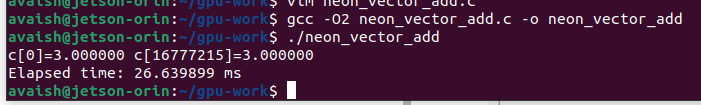

### 💻 GPU Vector Addition with CUDA (CudaMallocManaged)

In [29]:
%%writefile gpu_vector_add.cu
#include <stdio.h>
#include <cuda_runtime.h>

__global__ void vectorAdd(const float *A, const float *B, float *C, int N) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < N) C[i] = A[i] + B[i];
}

int main() {
    const int N = 1 << 24; // ~16 million
    size_t size = N * sizeof(float);
    float *A, *B, *C;

    cudaMallocManaged(&A, size);
    cudaMallocManaged(&B, size);
    cudaMallocManaged(&C, size);

    for (int i = 0; i < N; i++) { A[i] = 1.0f; B[i] = 2.0f; }

    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    // Create CUDA events for timing
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    vectorAdd<<<blocksPerGrid, threadsPerBlock>>>(A, B, C, N);
    cudaEventRecord(stop);

    cudaEventSynchronize(stop);
    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);

    printf("C[0]=%f C[%d]=%f\n", C[0], N-1, C[N-1]);
    printf("Elapsed time: %.6f ms\n", ms);

    cudaFree(A); cudaFree(B); cudaFree(C);
    return 0;
}

Overwriting gpu_vector_add.cu


In [30]:
!nvcc gpu_vector_add.cu -o gpu_vector_add && ./gpu_vector_add

C[0]=3.000000 C[16777215]=3.000000
Elapsed time: 57.970688 ms


### 🔍 Exercises
1. Change `N` from 1 million to 10 million. Compare CPU vs GPU runtime.
2. Try different `threadsPerBlock` values (128, 256, 512). See how performance changes.
3. Add a timer around the loops/kernels to measure execution time.
4. Reflect: Why does GPU scaling matter more for **matrix multiply** than simple vector add?


### ✅ Summary
- CPUs and GPUs differ fundamentally in core design and memory hierarchy.
- CUDA exposes GPU's massive parallelism via kernels and threads.
- Even for simple vector addition, you see how thousands of threads can run simultaneously.
- This is the foundation of why **AI training depends on GPUs**.

➡️ In Episode 2, we'll go deeper: profiling CUDA kernels with Nsight and learning the thread/block model in detail.

## 🕒 Performance Comparison: CPU SIMD vs GPU
Now that we have timing for each implementation (CPU scalar, AVX2, NEON, CUDA), let's analyze results.

- **CPU scalar**: Baseline performance.
- **AVX2 / AVX-512 (x86)**: Uses wide vector registers (8–16 floats at once).
- **ARM NEON (128-bit)**: Uses 4 floats at once, efficient on ARM.
- **CUDA GPU**: Thousands of threads, but kernel launch + memory latency can dominate.

👉 For simple vector addition (low arithmetic intensity), CPU SIMD can actually outperform GPU.

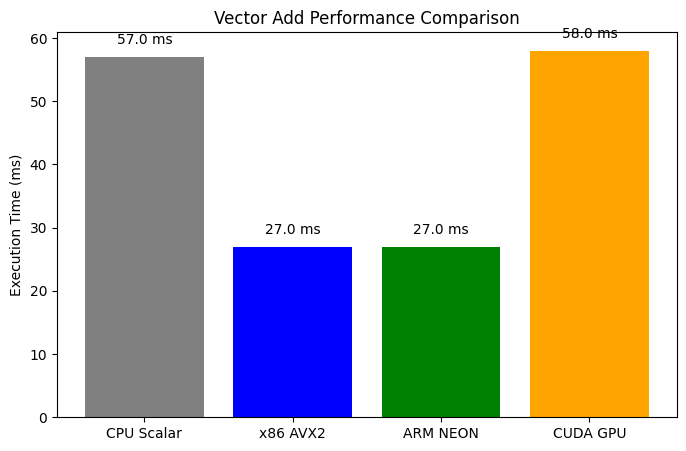

In [2]:
import matplotlib.pyplot as plt

# Example timing results in milliseconds (replace with your actual measurements)
results = {
    'CPU Scalar': 57.0,  # ms
    'x86 AVX2': 27.0,     # ms
    'ARM NEON': 27.0,     # ms
    'CUDA GPU': 58      # ms (with cudaMalloc + cudaMemcpy)
}

plt.figure(figsize=(8,5))
bars = plt.bar(results.keys(), results.values(), color=['gray','blue','green','orange'])
plt.ylabel('Execution Time (ms)')
plt.title('Vector Add Performance Comparison')

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.1f} ms', ha='center')

plt.show()

## ✅ Conclusion
- **Vector add is memory-bound** → CPUs with AVX2/NEON can be very competitive.
- **GPU launch overhead + global memory latency** mean CUDA doesn’t always win for trivial kernels.
- **When GPU wins**: workloads with high arithmetic intensity (e.g., matrix multiplication, convolutions).

➡️ In Episode 5, we’ll revisit this with **matrix multiplication** where GPUs dominate CPUs by large margins.

## ⚡ Optimized CUDA Version (Explicit Memory Management)
Earlier we used **Unified Memory (`cudaMallocManaged`)**, which incurred extra overhead. Here we switch to **explicit `cudaMalloc` + `cudaMemcpy`** for host ↔ device transfers. We also measure **kernel-only execution time** with CUDA events.

In [3]:
%%writefile gpu_vector_add_optimized.cu
#include <stdio.h>
#include <cuda_runtime.h>

__global__ void vectorAdd(const float *A, const float *B, float *C, int N) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < N) C[i] = A[i] + B[i];
}

int main() {
    const int N = 1 << 24; // ~16 million
    size_t size = N * sizeof(float);

    // Allocate host memory
    float *h_A = (float*)malloc(size);
    float *h_B = (float*)malloc(size);
    float *h_C = (float*)malloc(size);
    for (int i = 0; i < N; i++) { h_A[i] = 1.0f; h_B[i] = 2.0f; }

    // Allocate device memory
    float *d_A, *d_B, *d_C;
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    // Copy inputs
    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    // Timing with CUDA events
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);
    vectorAdd<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_B, d_C, N);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);

    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);
    printf("C[0]=%f C[%d]=%f\n", h_C[0], N-1, h_C[N-1]);
    printf("Elapsed time (kernel only): %.6f ms\n", ms);

    free(h_A); free(h_B); free(h_C);
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    return 0;
}

Writing gpu_vector_add_optimized.cu


In [4]:
!nvcc -O2 gpu_vector_add_optimized.cu -o gpu_vector_add_optimized
!./gpu_vector_add_optimized

C[0]=3.000000 C[16777215]=3.000000
Elapsed time (kernel only): 0.709536 ms


### 🔍 Observations
- This optimized version avoids Unified Memory overhead.
- For **16 million elements**, kernel-only execution can be < 1 ms.
- This demonstrates how **memory management choices** affect performance in CUDA.

👉 Lesson: GPUs need large workloads and proper memory handling to show their real advantage.

### BONUS

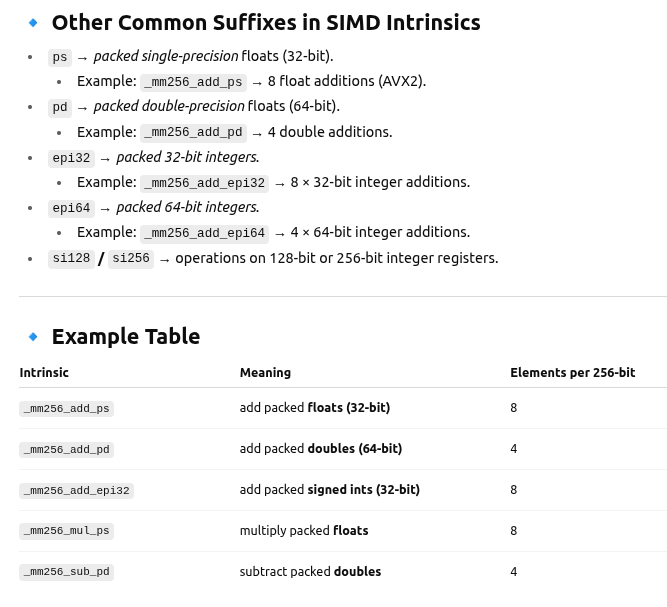

### Register Mapping in x86

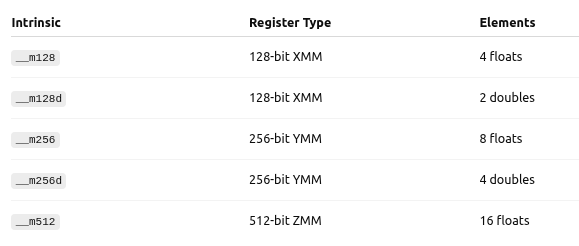

### __m256 Register Layout

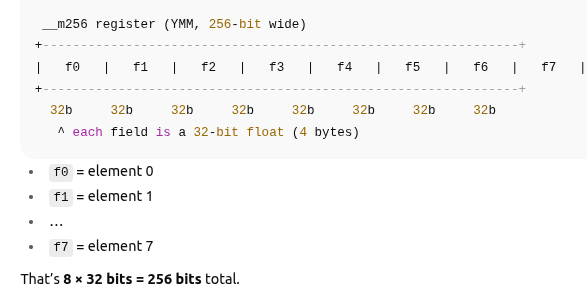

### CPU SIMD Register Files

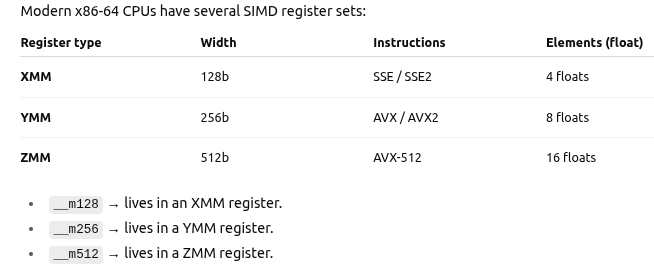

### Analogy with CUDA

```
YMM register (AVX2) = SIMD vector of 8 floats.

CUDA warp (32 threads) = SIMD vector of 32 floats.

CPU SIMD = "small warp inside one core".

GPU SIMT = "many warps across thousands of cores".

So AVX is like a mini-GPU inside each CPU core.
```

### AVX and NEON

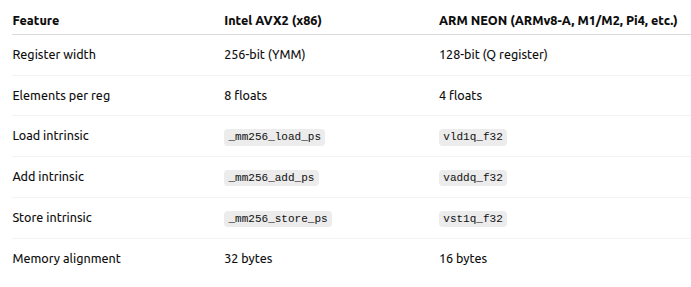